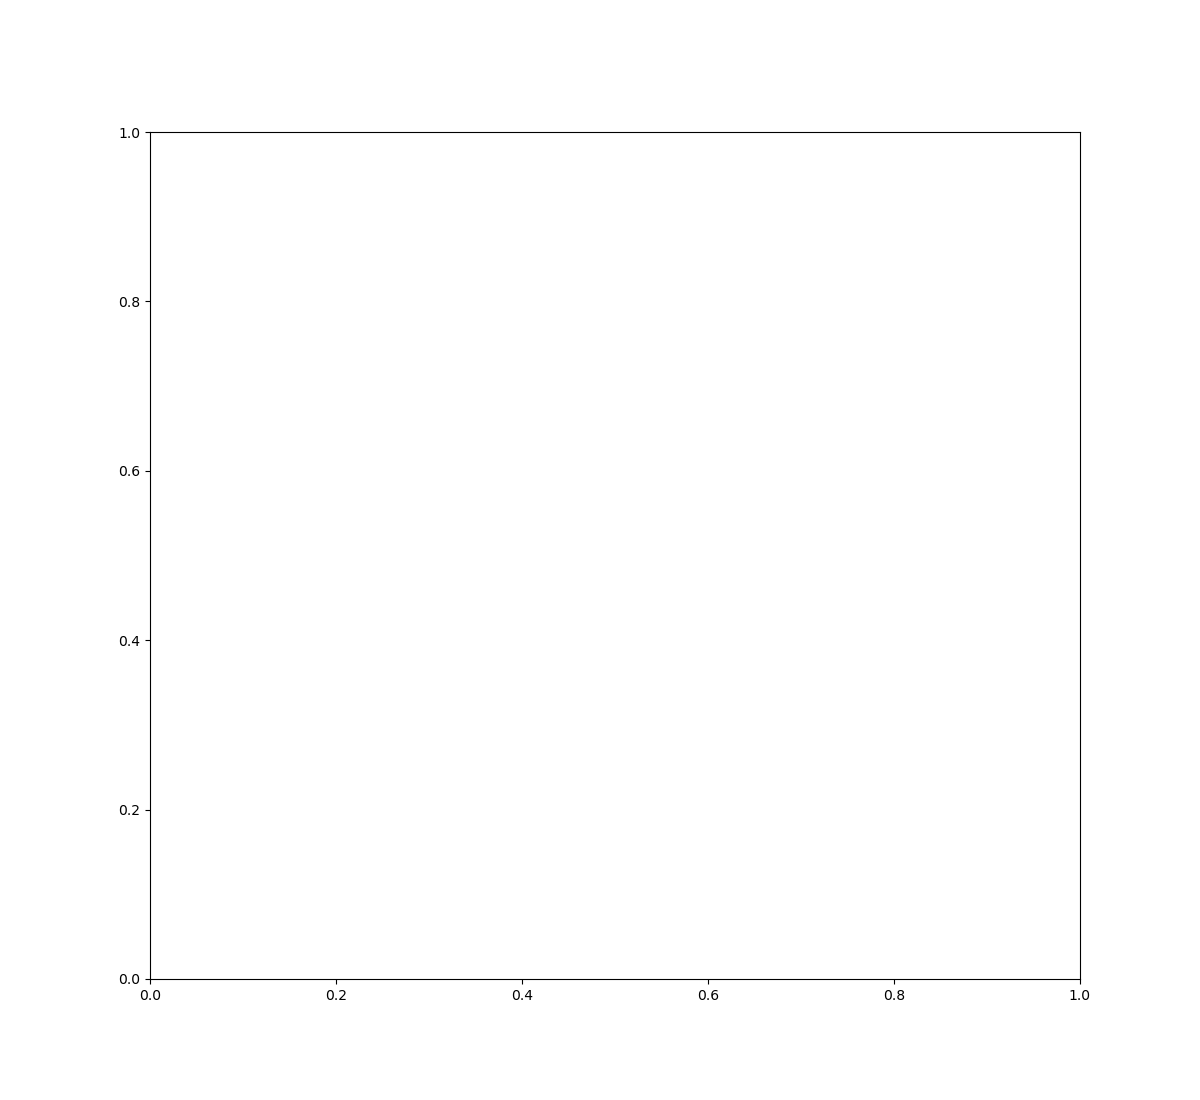

In [7]:
# %matplotlib widget
import torch
import gas
import cart
import numpy as np

import matplotlib.pyplot as plt

import time
plt.ion()

# if __name__ == '__main__':
sz = (512, 512) 
device = 'cuda'
dataType = torch.float32
CFL = torch.tensor([0.5], device=device, dtype=dataType)
tOuts = [0, 1]
see = 10

gamma = torch.tensor([1.4], device=device, dtype=dataType)
uBack = torch.tensor([1, 0, 0, 2.5], device=device, dtype=dataType)
uBlock = torch.tensor([0.5, -1, 0, 4], device=device, dtype=dataType)

xs = torch.linspace(0, 1, sz[0] + 1, device=device, dtype=dataType)
ys = torch.linspace(0, 1, sz[1] + 1, device=device, dtype=dataType)

rs = torch.tensor(range(sz[0]), device=device, dtype=torch.long)
ss = torch.tensor(range(sz[1]), device=device, dtype=torch.long)

rsm, ssm = torch.meshgrid(rs, ss, indexing='ij')

xc = 0.5 * (xs[:-1] + xs[1:])
yc = 0.5 * (ys[:-1] + ys[1:])

hx = xs[1:] - xs[:-1]
hy = ys[1:] - ys[:-1]

hxm, hym = torch.meshgrid(hx, hy, indexing='ij')
xcm, ycm = torch.meshgrid(xc, yc, indexing='ij')

hLe = xcm - cart.Le(xcm)
hRi = cart.Ri(xcm) - xcm
hLo = ycm - cart.Lo(ycm)
hUp = cart.Up(ycm) - ycm
hLe[0, :] = hLe[1, :]
hRi[-1, :] = hLe[-2, :]
hLo[:, 0] = hLo[:, 1]
hUp[:, -1] = hUp[:, -2]

vol = hxm * hym

ifwBLe = rsm == 0
ifwBRi = rsm == sz[0] - 1
ifwBLo = ssm == 0
ifwBUp = ssm == sz[1] - 1
ifBlock = (xcm < 0.75).logical_and_(xcm > 0.25).logical_and(
    ycm < 0.75).logical_and(ycm > 0.25)

wBLe = cart.sub2indFromBool(rsm, ssm, sz, ifwBLe)
wBRi = cart.sub2indFromBool(rsm, ssm, sz, ifwBRi)
wBLo = cart.sub2indFromBool(rsm, ssm, sz, ifwBLo)
wBUp = cart.sub2indFromBool(rsm, ssm, sz, ifwBUp)

block = cart.sub2indFromBool(rsm, ssm, sz, ifBlock)

u0 = torch.zeros((sz[0], sz[1], 4), device=device, dtype=dataType)

u0.view(-1, 4)[:, :] = uBack.view(1, 4)
u0.view(-1, 4)[block, :] = uBlock.view(1, 4)

# print(xcm)
# print(ycm)
# print(u0[:, :, 0])

u = u0

t = 0.0
iOut = 0

fig, ax = plt.subplots()
fig.set_size_inches((12,11))
plt.show()


umax 1.4247668981552124


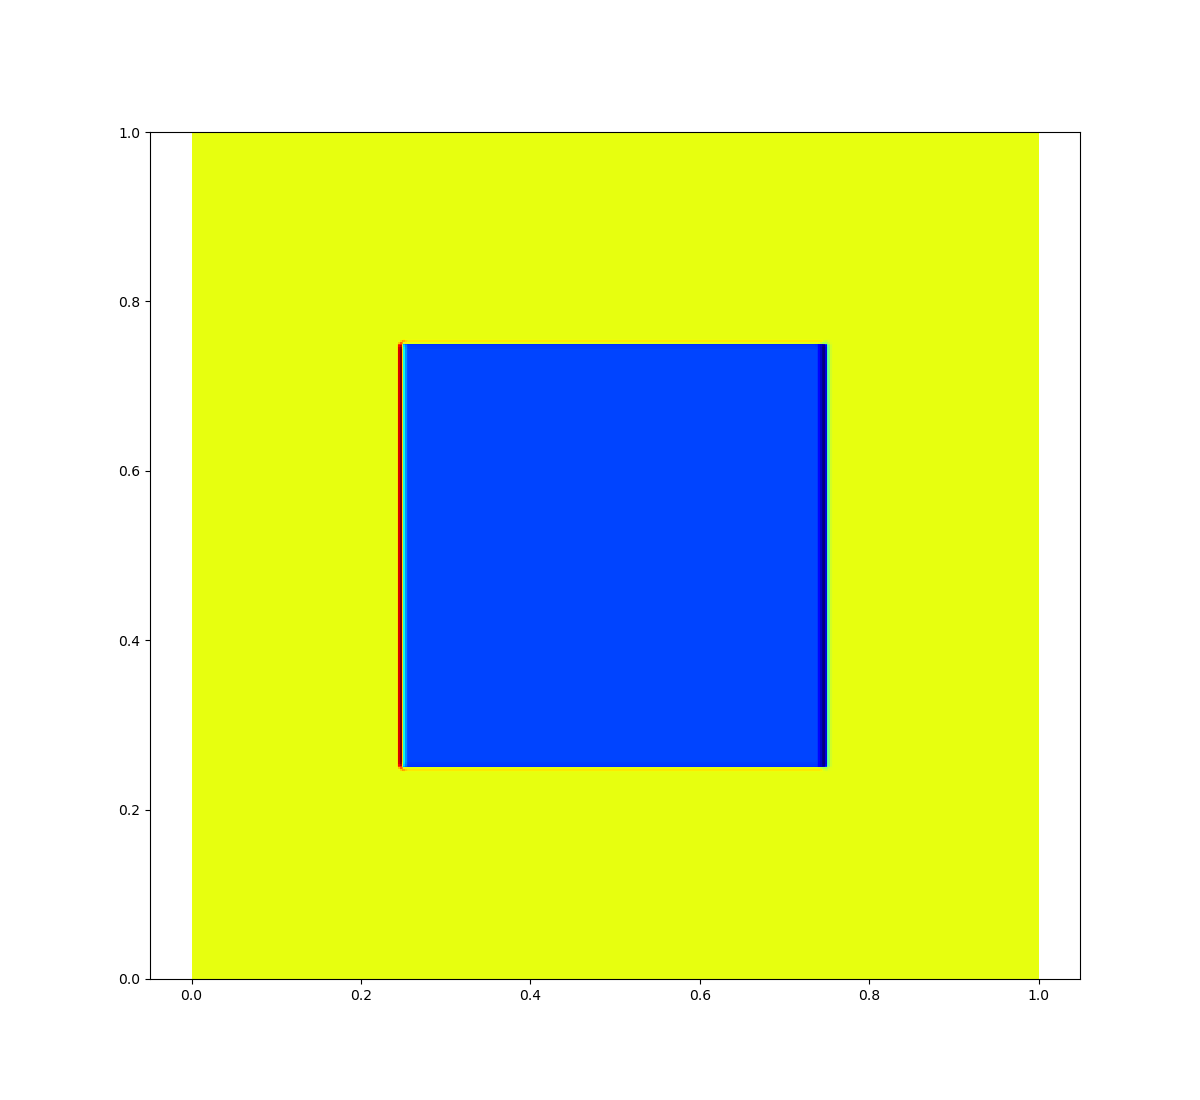

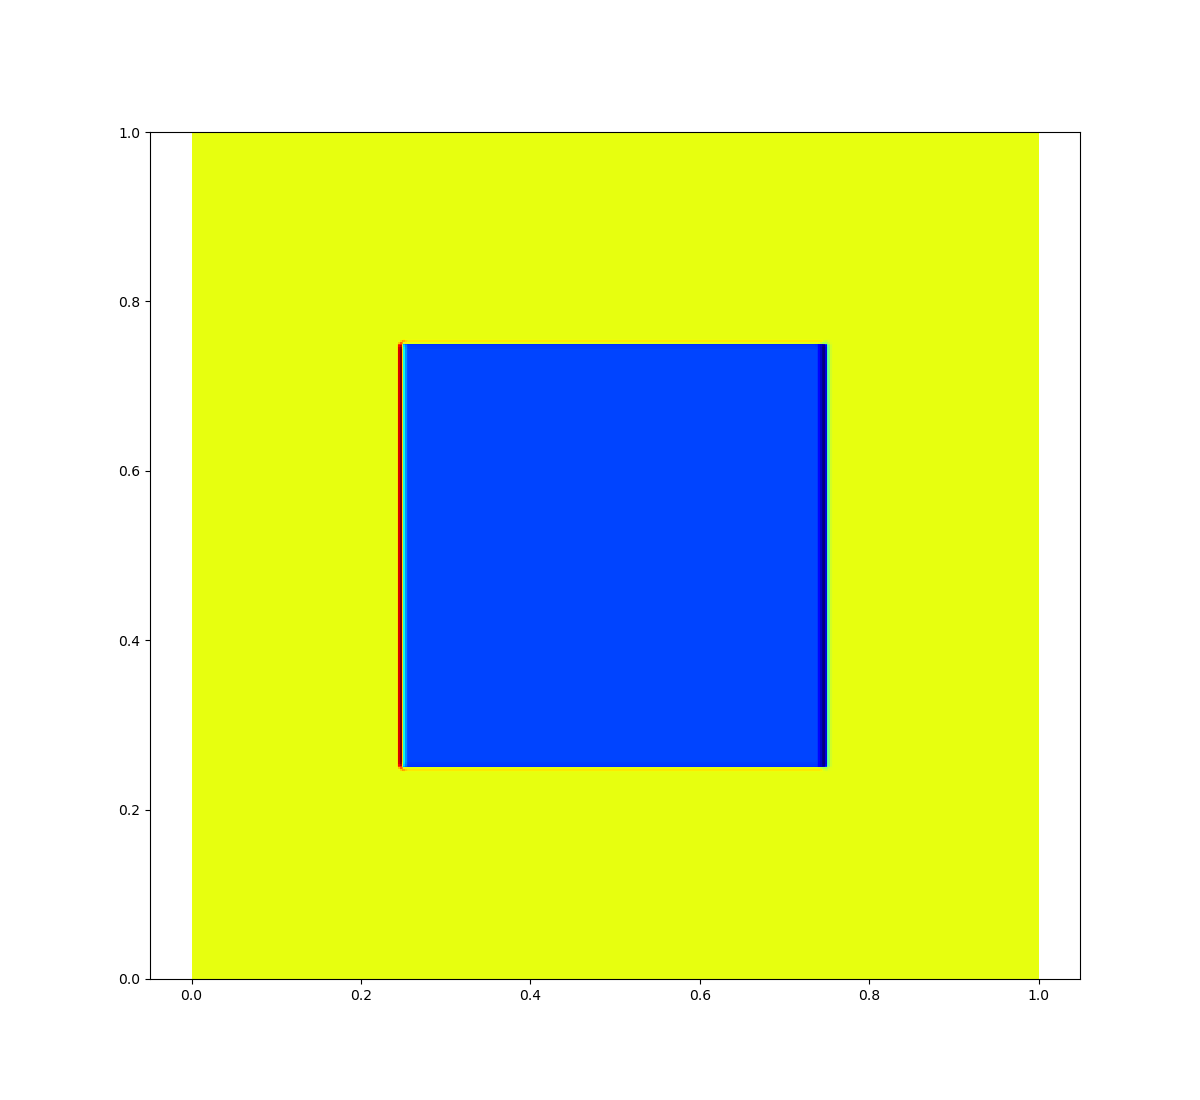

iter 10, t = [2.2862e-03], dt = [2.5475e-04], cpuTime = [2.02e+00]
umax 1.705847144126892


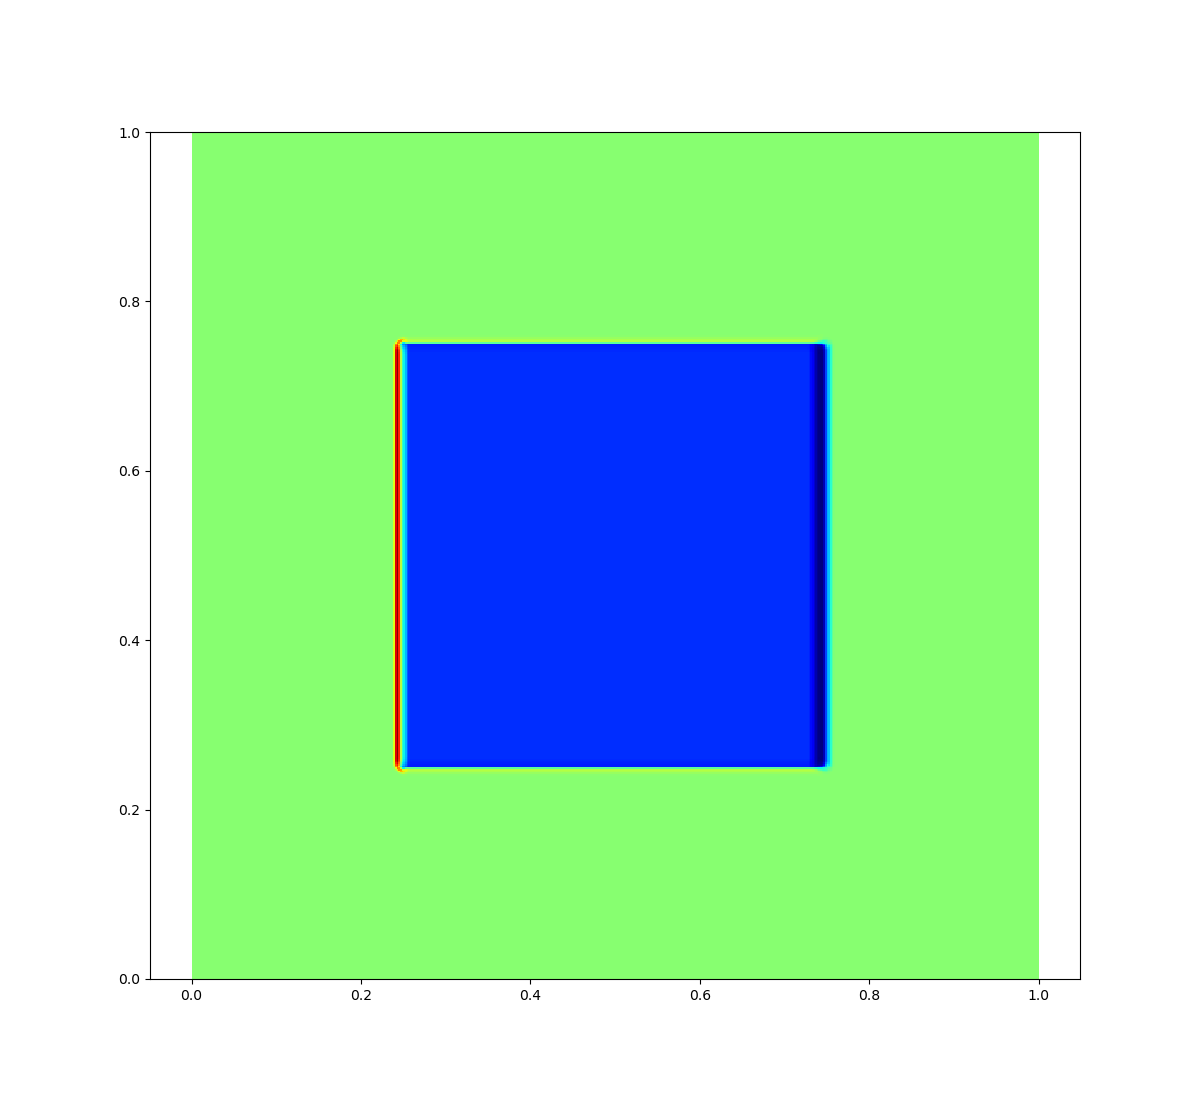

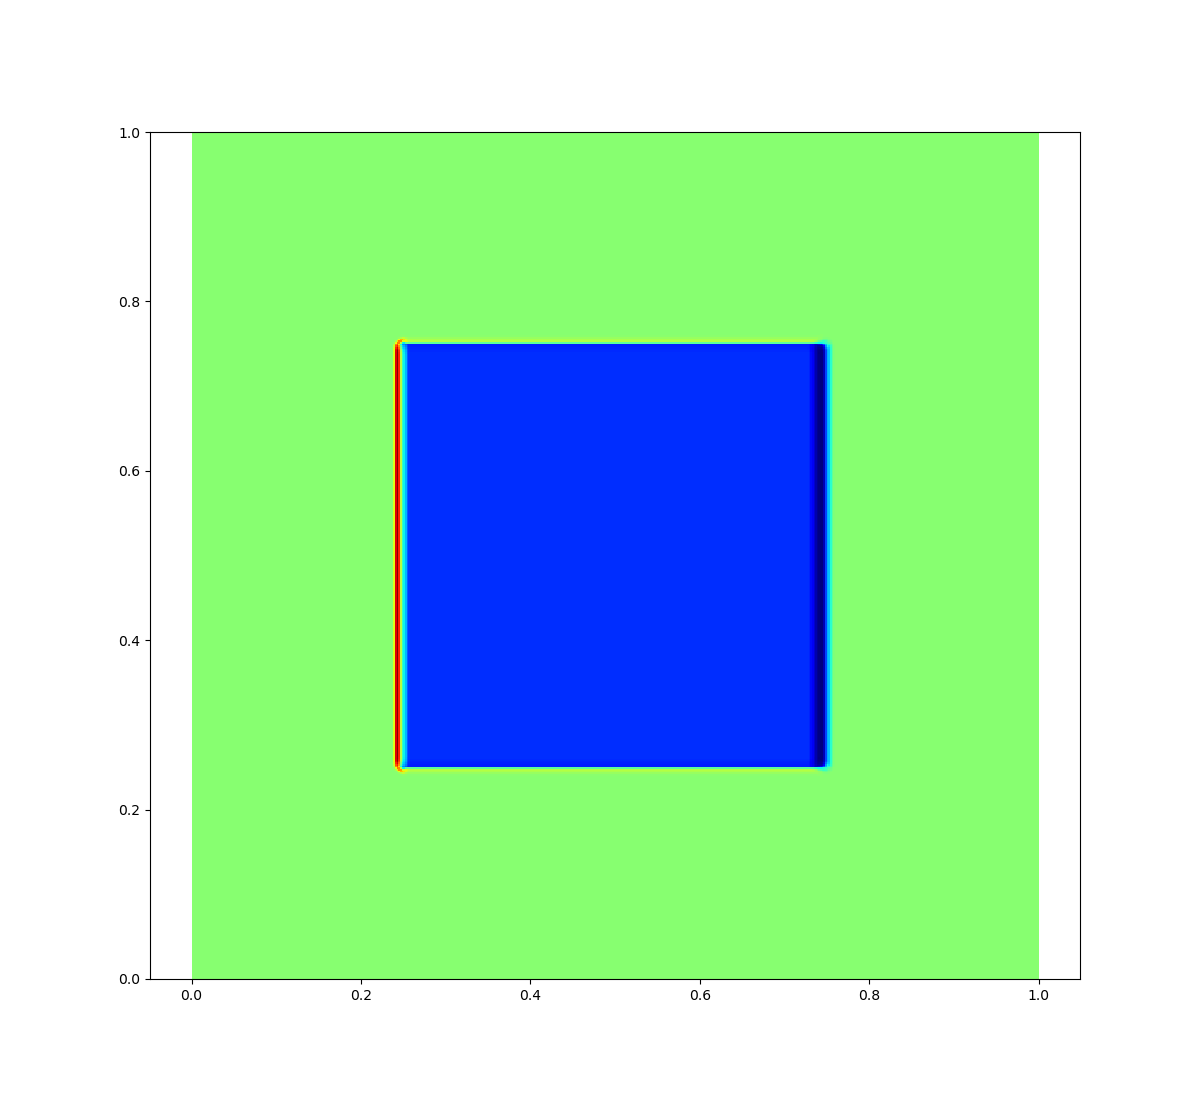

iter 20, t = [4.8339e-03], dt = [2.5476e-04], cpuTime = [2.07e+00]
umax 1.841705322265625


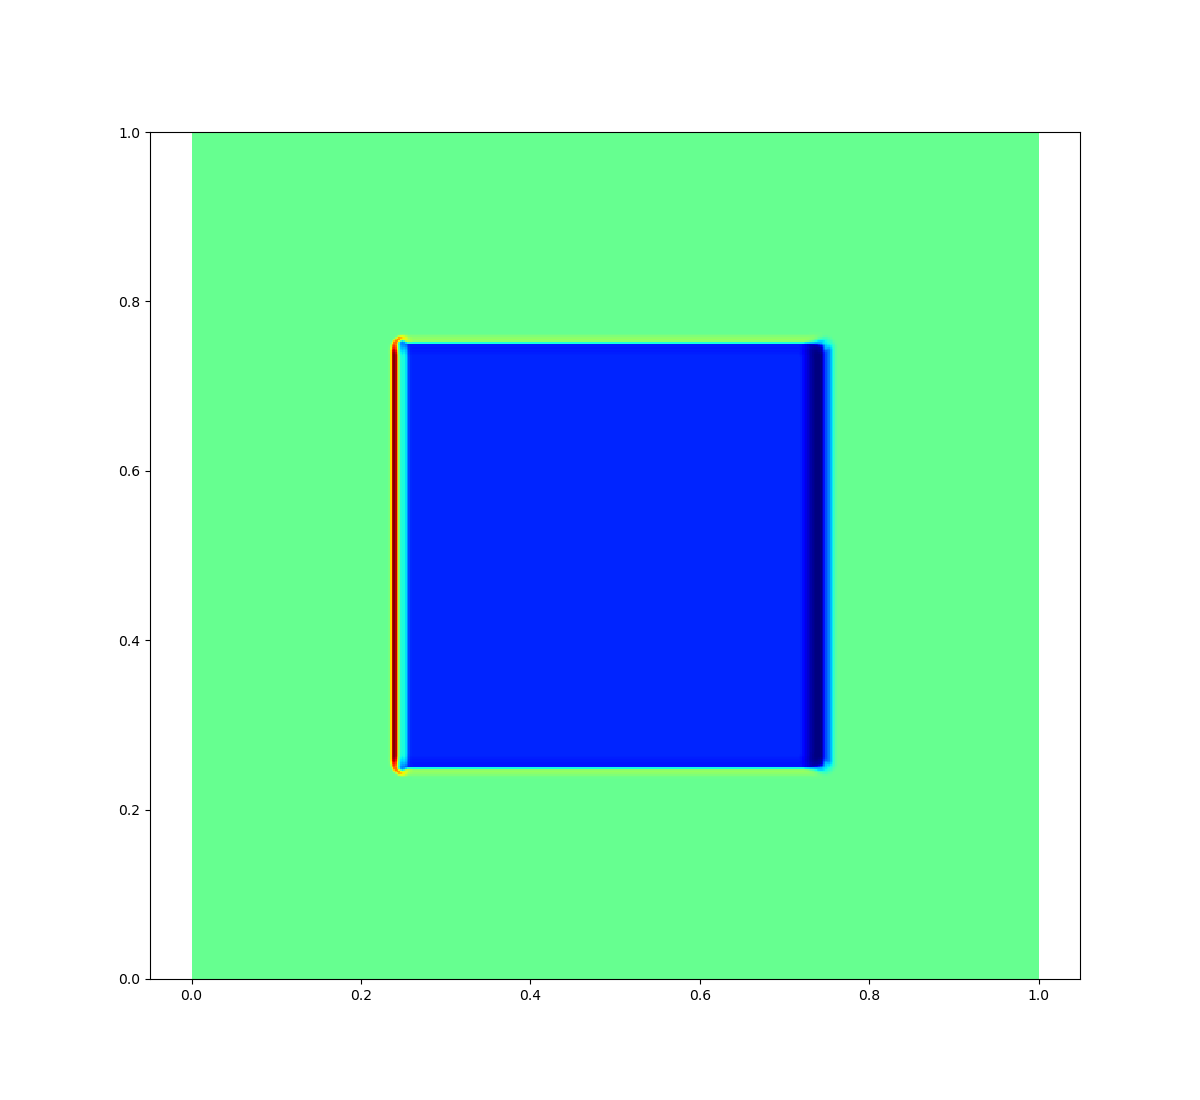

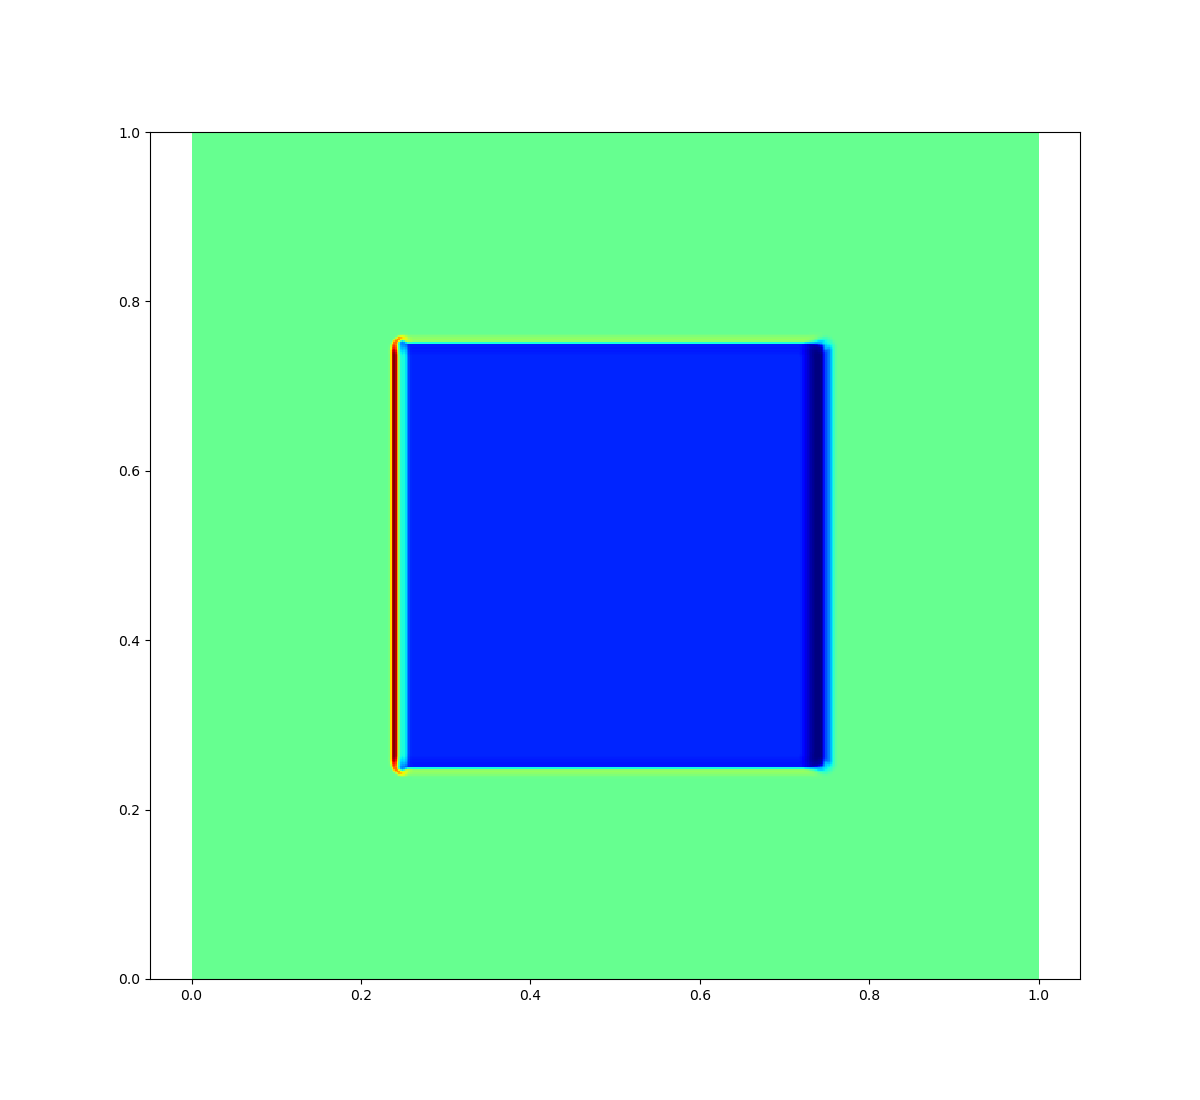

iter 30, t = [7.3815e-03], dt = [2.5476e-04], cpuTime = [2.07e+00]
umax 1.9087638854980469


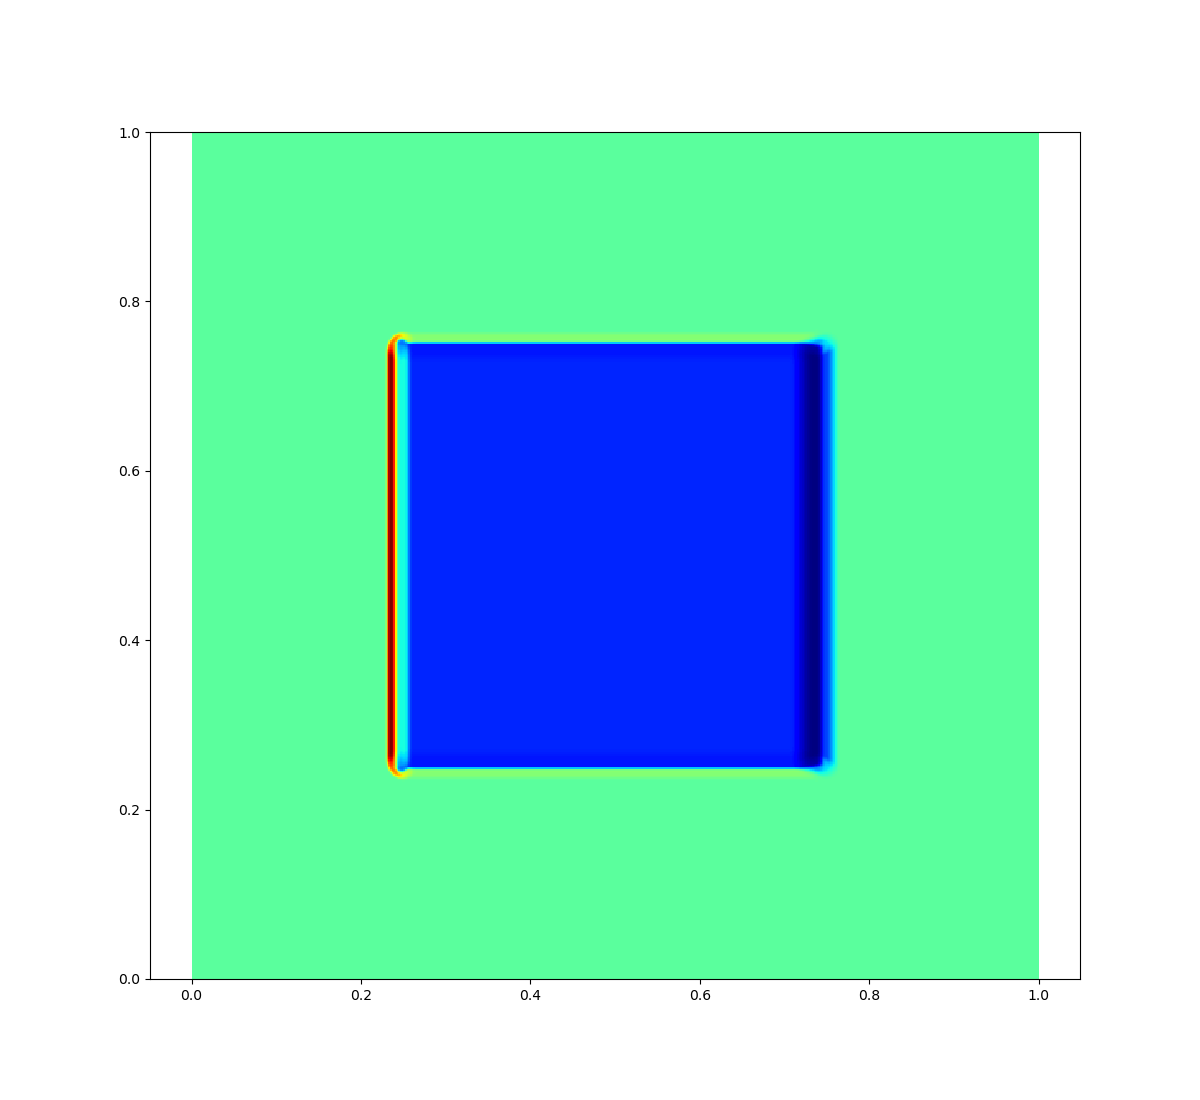

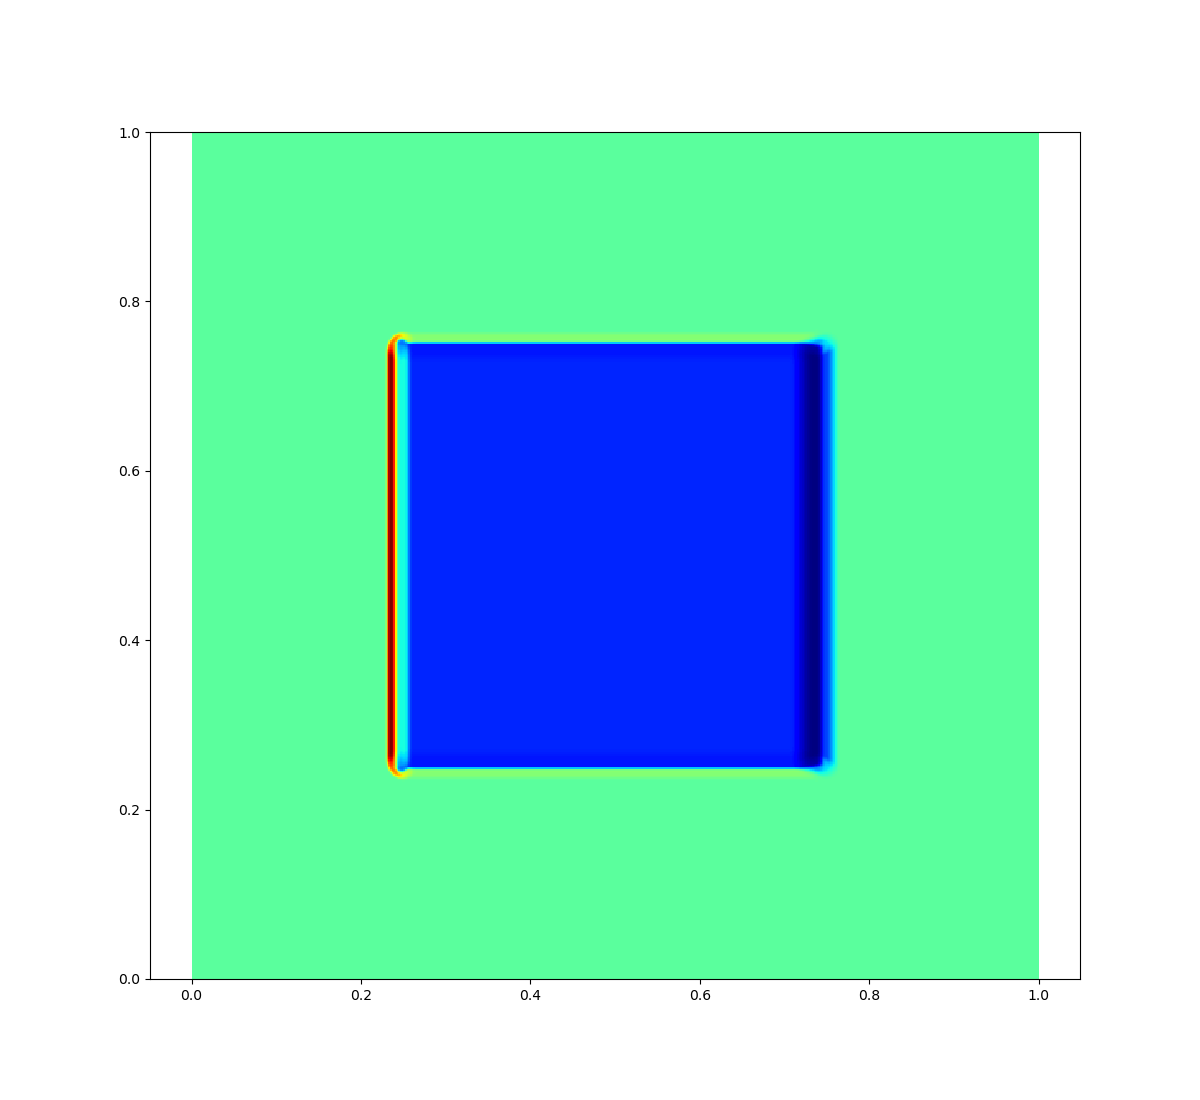

iter 40, t = [9.9292e-03], dt = [2.5477e-04], cpuTime = [2.07e+00]
umax 1.9393666982650757


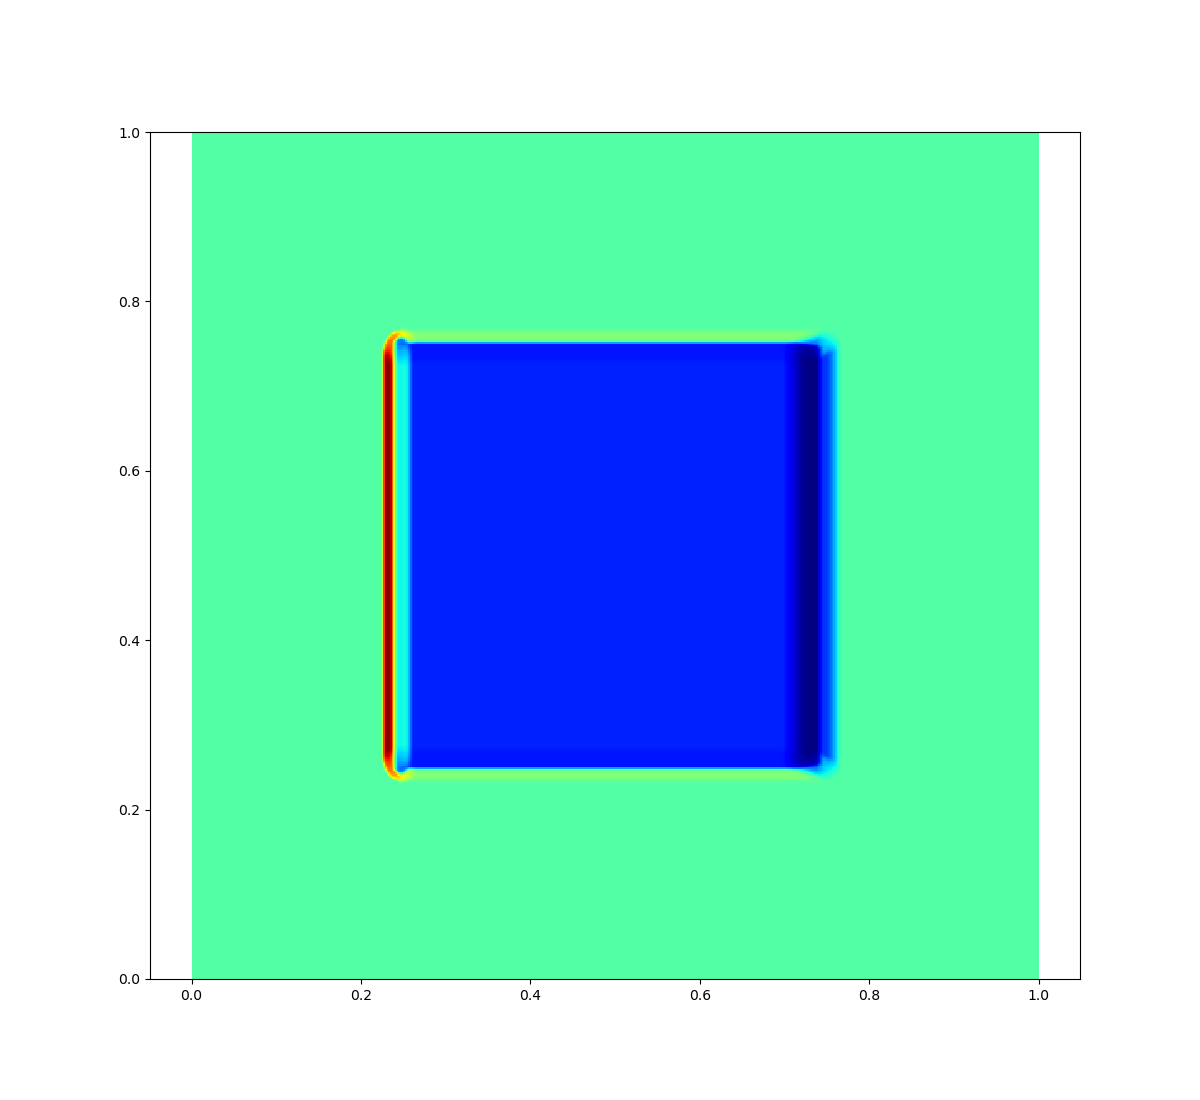

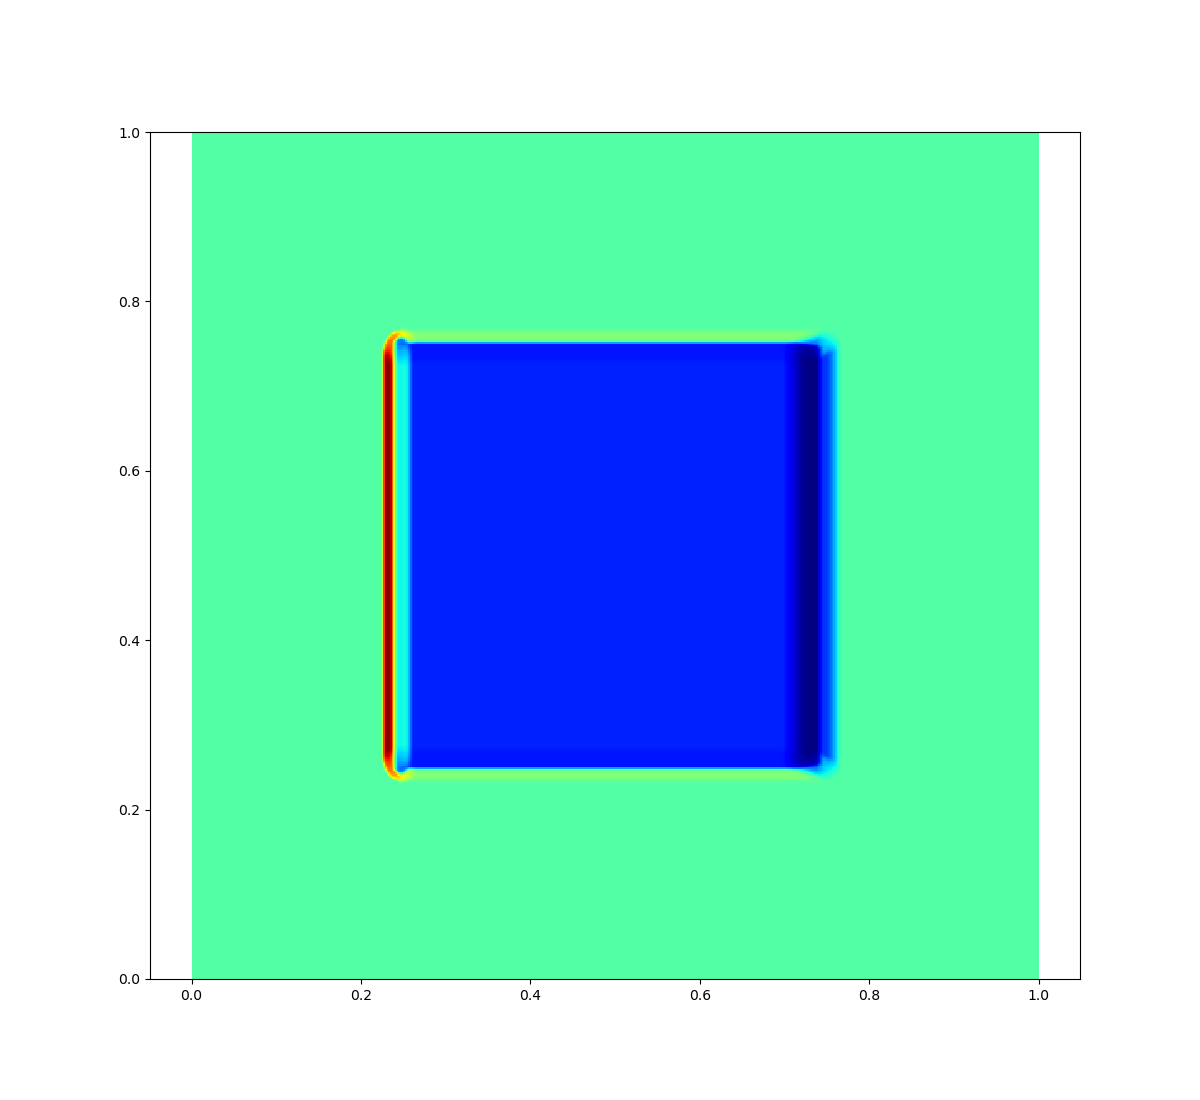

iter 50, t = [1.2477e-02], dt = [2.5477e-04], cpuTime = [2.07e+00]
umax 1.9521586894989014


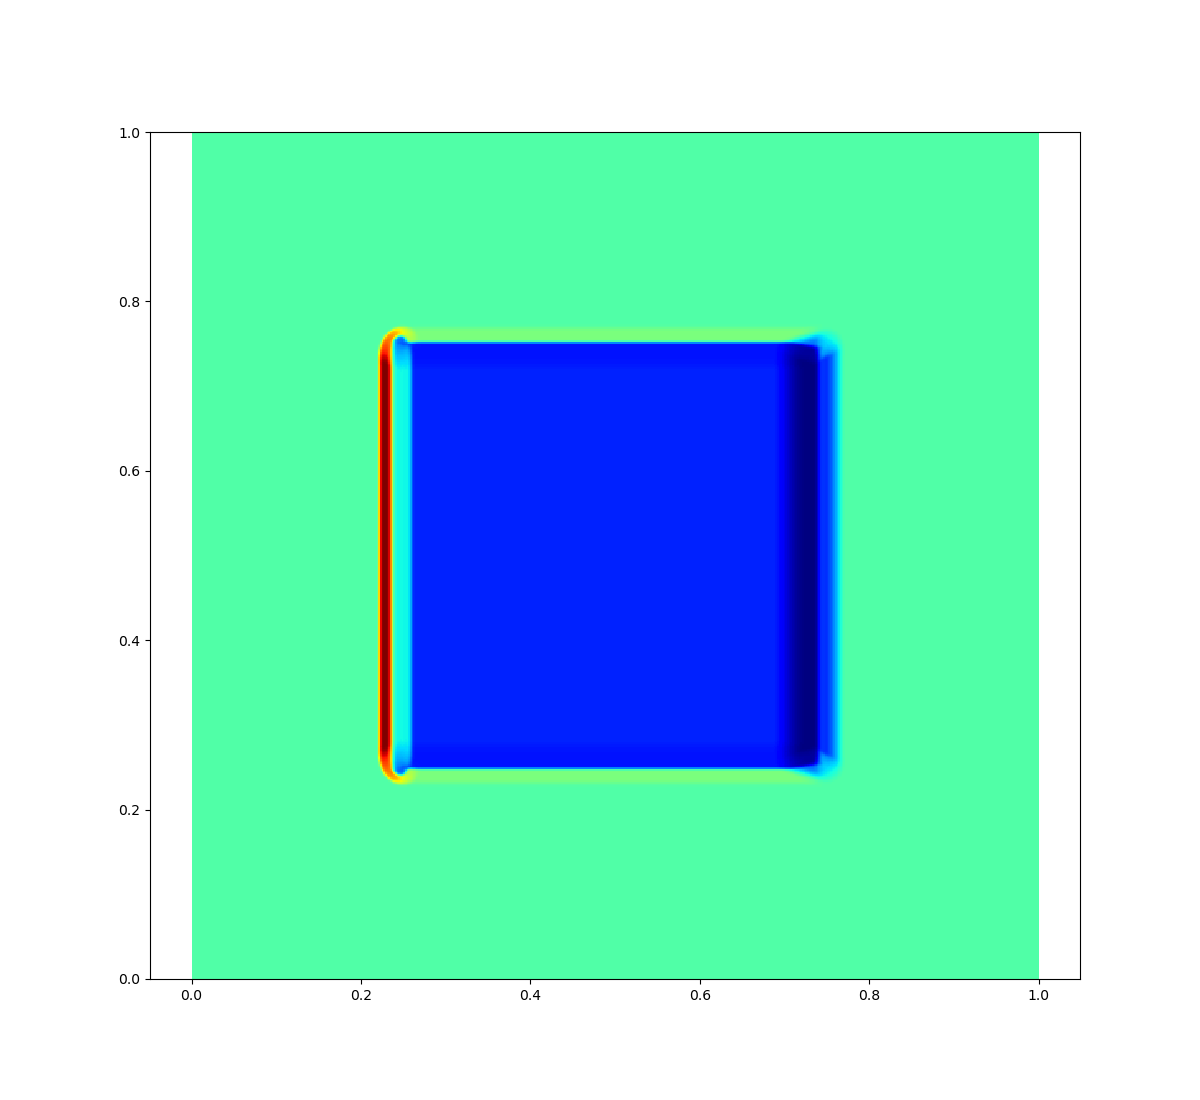

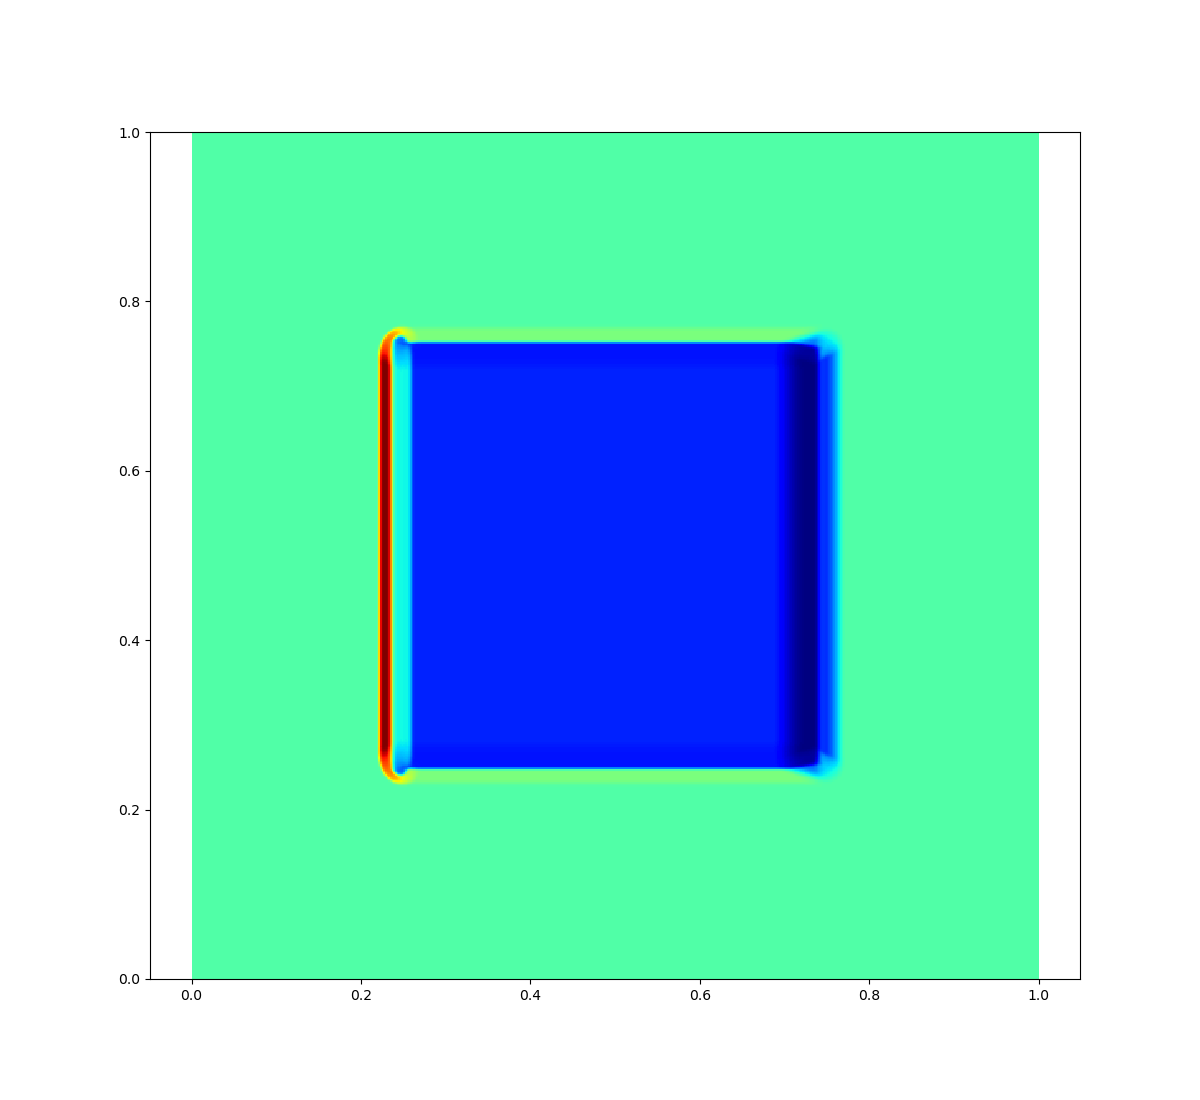

iter 60, t = [1.5025e-02], dt = [2.5477e-04], cpuTime = [2.08e+00]
umax 1.9578627347946167


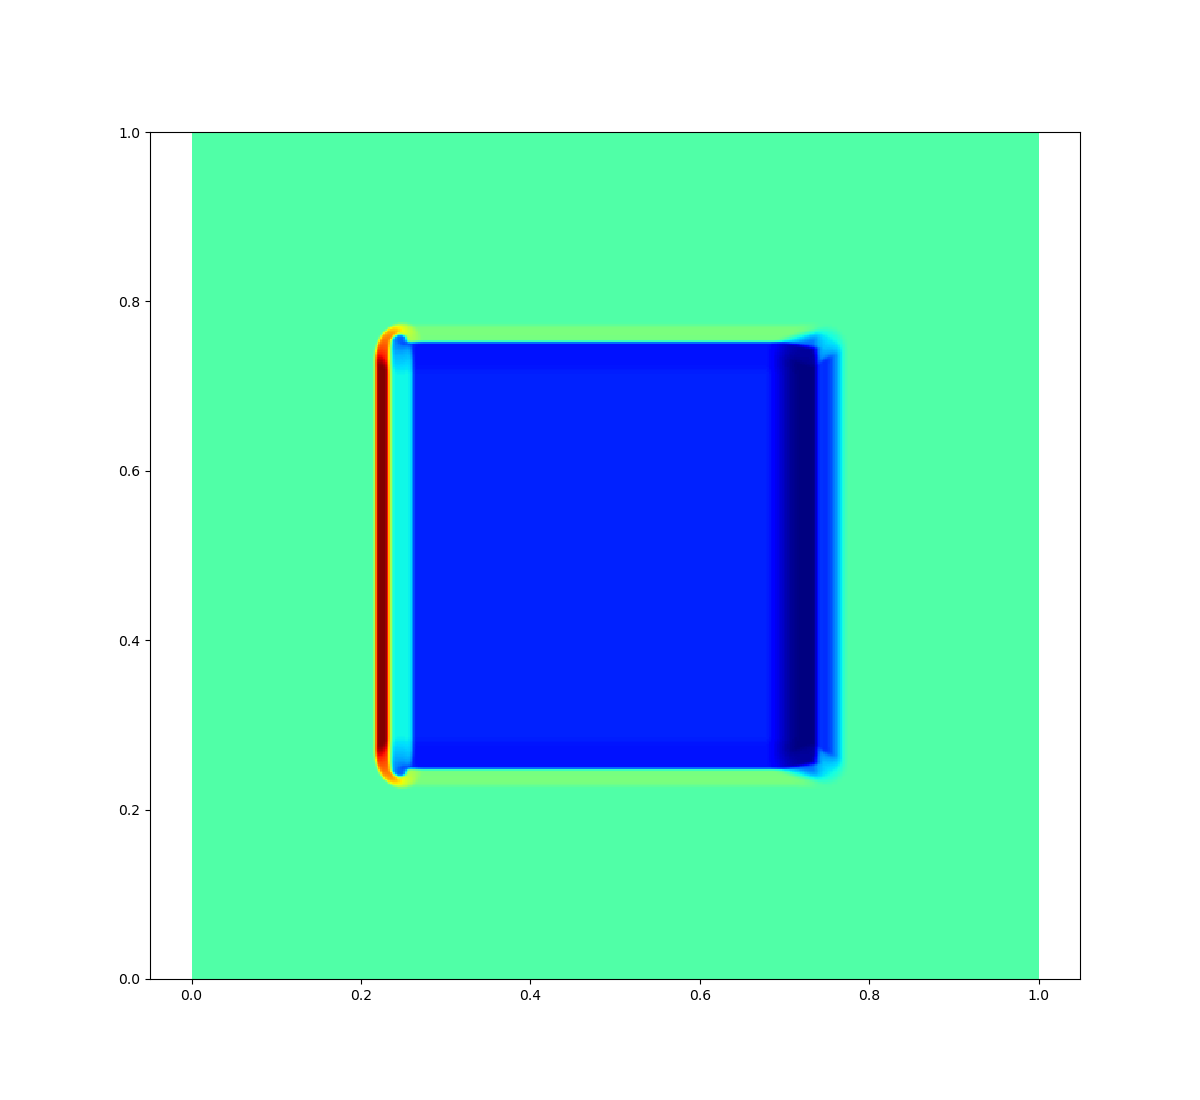

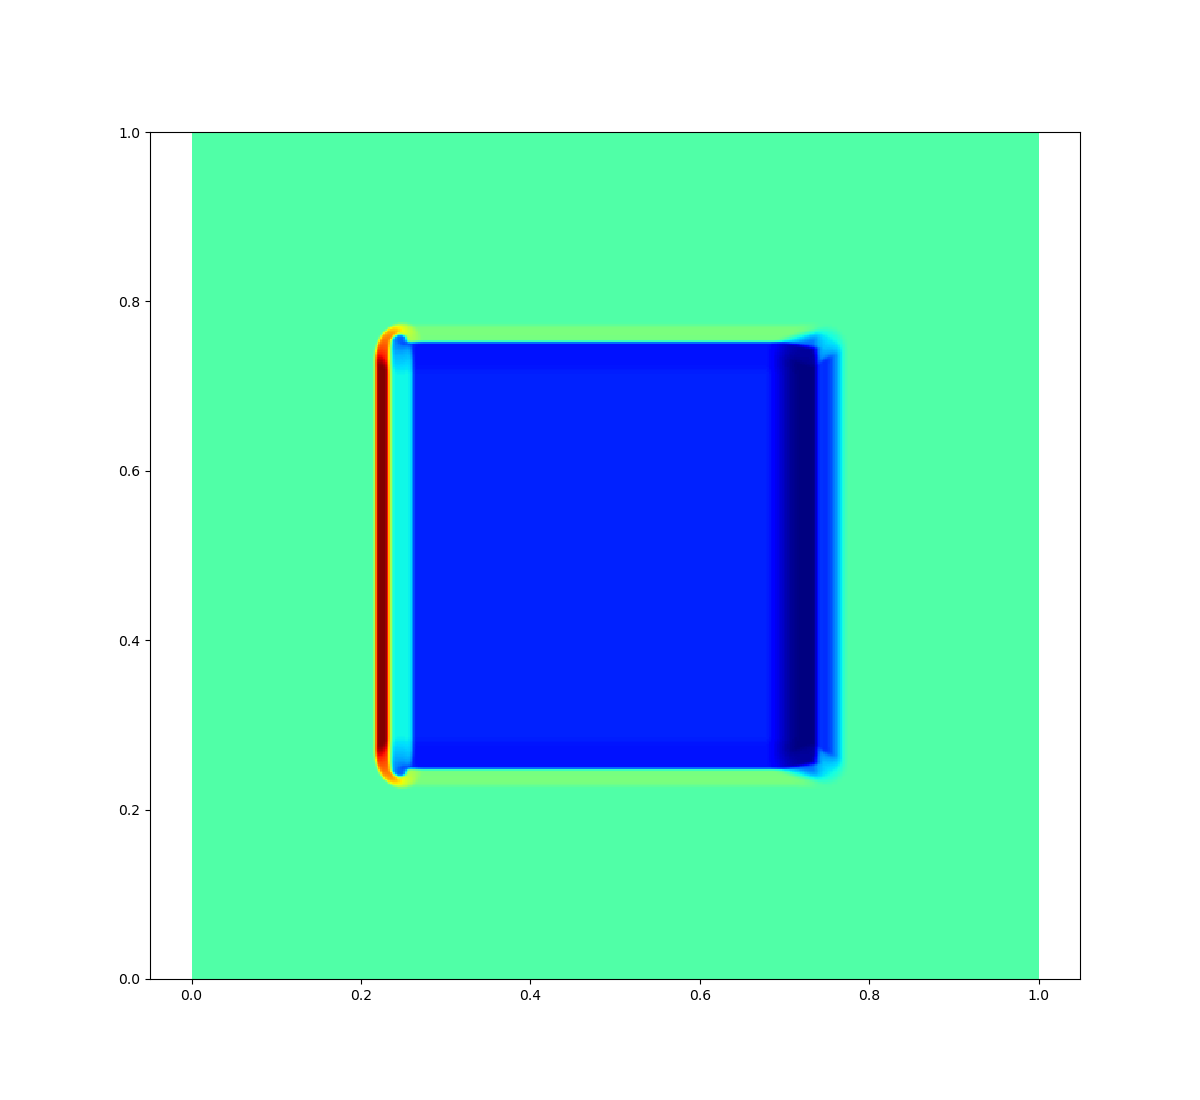

KeyboardInterrupt: 

In [ ]:
tic = time.perf_counter()
for iter in range(1, 10000000 + 1):
    UxMax = gas.F_u2maxLamX(u, gamma)
    uy = u.clone()
    gas.F_u_xfce2yfce(uy)
    UyMax = gas.F_u2maxLamX(uy, gamma)
    dtx = hxm / UxMax
    dty = hym / UyMax
    dtCFL = dtx.minimum(dty).min() * CFL
    dt = dtCFL
    ifOut = False
    if t + dt >= tOuts[iOut]:
        ifOut = True
        dt = tOuts[iOut] - t

    dudt0 = gas.EulerCartRHS(
        u,
        hLe,
        hRi,
        hLo,
        hUp,
        hxm,
        hym,
        vol,
        wBLe,
        wBRi,
        wBLo,
        wBUp,
        uBack,
        uBack,
        uBack,
        uBack,
        gamma,
    )
    u1 = u + dt * dudt0
    gas.F_FixU(u1, gamma)
    dudt1 = gas.EulerCartRHS(
        u1,
        hLe,
        hRi,
        hLo,
        hUp,
        hxm,
        hym,
        vol,
        wBLe,
        wBRi,
        wBLo,
        wBUp,
        uBack,
        uBack,
        uBack,
        uBack,
        gamma,
    )
    unew = 0.5 * u + 0.5 * u1 + 0.5 * dt * dudt1
    gas.F_FixU(unew, gamma)
    u = unew.clone()

    t = t + dt

    if ifOut:
        iOut += 1
        if iOut >= len(tOuts):
            break
        pass

    if iter % see == 0:

        rho = u[:, :, 0]
        print(f"umax {rho.max().cpu()}")

        # with plt.ion():
        # fig.clear()
        # fig.clf()
        ax.cla()
        ax.pcolormesh(xcm.cpu(), ycm.cpu(), rho.cpu(), shading="auto", cmap="jet")
        ax.axis("equal")
        # plt.show(block=False)
        # fig.canvas.draw()
        # plt.pause(0.1)
        # time.sleep(1)
        fig.savefig('out/cfig.png')

        print(
            "iter %d, t = [%.4e], dt = [%.4e], cpuTime = [%.2e]"
            % (iter, t, dt, (time.perf_counter() - tic))
        )
        # print(rho.max())
        tic = time.perf_counter()

In [ ]:

fig1, ax1 = plt.subplots()
rho = u[:, :, 0]

ax1.cla
ax1.pcolormesh(xcm.cpu(), ycm.cpu(), rho.cpu())
ax1.axis('equal')
plt.show()
